# Multi-surface plasticity model

In this example, we show how to implement a multi-surface elasto-plastic constitutive model that combines several yield surfaces.

```{admonition} Objectives
:class: important

This demo is to illustrate how to:

- Define a custom multi-surface plasticity model in `jaxmat`.

- Combine several yield surfaces and associated yield stresses within the same constitutive update.

- Use Fischer-Burmeister functions to tackle plastic complementarity, thereby avoiding an explicit tracking of active/inactive yield surfaces.

- Validate the implementation by visualizing the resulting stress paths in the $(p, q)$ (mean–deviatoric) stress space.
```

For the sake of illustration, we consider a Drucker–Prager yield surface describing the main frictional effect in the plasticity of several geomaterials. We also add an elliptic cap in compression and a hydrostatic tension cutoff. Assuming no hardening, we plot the final yield surface obtained from various strain-driven load paths in the hydrostatic/deviatoric $(p,q)$-plane.

## Multi-surface plasticity setting

We consider $i=1,\ldots, N$ different yield surfaces. Each of them is associated with its own yield stress function $f_i(\bsig)$ and yield stress $\sigma_{0i}$. Here, we do not consider any hardening so the yield stresses are all constants. However it is possible to account for independent isotropic hardening of each surface. Hence, each yield surface is associated with its own plastic multiplier, which we denote $p_i$ [^1].

[^1] : This is an abuse of notation regarding the classical cumulated plastic strain of standard $J_2$-plasticity, we should rather denote them $\lambda_ i$. We chose the notation $p_i$ to keep the implementation as close as possible to simpler plastic behaviors.

### Generalized flow rule

For a smooth yield surface $f(\bsig)$, we now that the associated flow rule is expressed as $\dot{\bepsp}=\dot{\lambda}\partial_{\bsig} f$. In the non-smooth case, the flow rule generalizes as follows:

$$
\dot{\bepsp}=\dot{\lambda}\bn \quad \text{where } \bn\in \Nn_{f}(\bsig)
$$

where $\Nn_f$ is the normal cone to the plastic surface $f$. For smooth parts $\Nn_f(\bsig)=\{\partial_{\bsig} f\}$ contains only a single normal vector element. In the case of many surfaces intersecting at $\bsig$, $\bn$ can take any value belonging to a positive convex combination of the normal vectors $\bn_i=\partial_{\bsig}f_i$ of each surface:

$$
\dot{\bepsp} = \sum_{i=1}^N\dot{\lambda}_i \partial_{\bsig}f_i(\bsig)
$$

### Plastic complementarity conditions

The evolution of these quantities is determined implicitly by a return-mapping–like algorithm formulated as a root-finding problem. Classically, we should choose which surface is active, compute a projected stress and then check if the surface remains active. This active-set strategy is relatively cumbersome to implement. Instead, the use of complementarity functions such as Fischer-Burmeister functions allows to avoid explicitly testing which surface is active or not. Elastic and plastic evolution are simultaneously accounted for by requiring that, for all plastic mechanism $i$:

$$
\text{FB}(\sigma_0-f_i(\bsig), \Delta p_i) = 0 \quad \Leftrightarrow \quad f_i(\bsig)\leq \sigma_{0i},\: \Delta p_i \geq 0, \: (f_i(\bsig)-\sigma_{0i})\Delta p_i=0
$$

As a result, it is even possible with this formulation to account for two plastic mechanisms being simultaneously activated.

```{warning}
This approach does not remove all issues associated with non-smooth yield surfaces. Convergence issues might still appear, especially in the apex region.
```

## Implementation

We begin by defining an `InternalState` defining the model internal state variables: the total plastic strain $\bepsp$ and several plastic multipliers $p_i$ for each yield surface. Here, the plastic multipliers are represented as a vector of size $N$ (`n_surf` in the code).

We define the internal state as a PyTree-like Equinox dataclass with statically known attributes (`n_surf`), and dynamic arrays (`epsp` and `p`) that can be efficiently traced by JAX.

```{admonition} Why __post_init__ is used
:class: tip

Because `equinox` modules are immutable, fields that depend on other parameters (like the number of yield surfaces `n_surf`) cannot be directly initialized in the constructor.
The `__post_init__` method provides a clean way to perform such initialization after object creation.

Here, it allocates the array `p` with zeros of size `(n_surf,)`, ensuring that the internal variable dimensions automatically match the number of yield surfaces, the structure remains static and JAX-traceable, and the module follows Equinox’s immutable data model.

In short, __post_init__ lets us safely set up shape-dependent fields while keeping the model compatible with JAX transformations like `jit` and `vmap`.
```

In [ ]:
import jaxmat
import jax.numpy as jnp
import equinox as eqx
import optimistix as optx
from optax.tree_utils import tree_add, tree_zeros_like
from jaxmat.state import AbstractState
from jaxmat.tensors import SymmetricTensor2, dev, pq_invariants
from jaxmat.materials.behavior import SmallStrainBehavior
from jaxmat.materials.elasticity import LinearElasticIsotropic
from jaxmat.materials.plastic_surfaces import (
    AbstractPlasticSurface,
)
from jaxmat.tensors.utils import FischerBurmeister as FB
import jaxmat.materials as jm
import jax


import matplotlib.pyplot as plt


class InternalState(AbstractState):
    p: float = eqx.field(init=False)
    epsp: SymmetricTensor2 = SymmetricTensor2()
    n_surf: int = eqx.field(static=True, default=1)

    def __post_init__(self):
        self.p = jnp.zeros((self.n_surf,))

The `MultiSurfacePlasticity` class defines the main constitutive behavior.
It extends `SmallStrainBehavior` and is defined by several different fields: an elastic model, a list of yield surfaces, and a list of their corresponding yield stresses.

During initialization, the __post_init__ method checks that the number of yield surfaces matches the number of yield stresses, then sets the internal state (InternalState) with the correct number of plastic multipliers.
This ensures consistency and avoids manual setup when extending the model to more surfaces.

The `constitutive_update` method then performs an implicit return-mapping procedure using `optimistix.root_find`. The residuals correspond to the plasticity complementarity conditions of each surface, enforced using Fischer-Burmeister functions, and the incremental generalized plastic flow rules which leverage the normals of each surface. Note that the final residual, called `res`, is a PyTree as a nested list/tuple and does not need to be flattened. All residuals are then solved together within a single implicit solve.

Finally, the `@eqx.filter_jit` decorator enables JIT compilation for efficiency.

In [ ]:
class MultiSurfacePlasticity(SmallStrainBehavior):
    elastic_model: LinearElasticIsotropic
    yield_stresses: list[eqx.Module]
    plastic_surfaces: list[AbstractPlasticSurface]
    n_surf: int = eqx.field(static=True, default=1)
    internal: AbstractState = eqx.field(init=False)

    def __post_init__(self):
        assert len(self.yield_stresses) == len(self.plastic_surfaces)
        self.n_surf = len(self.plastic_surfaces)
        self.internal = InternalState(n_surf=self.n_surf)

    @eqx.filter_jit
    @eqx.debug.assert_max_traces(max_traces=1)
    def constitutive_update(self, eps, state, dt):
        eps_old = state.strain
        deps = eps - eps_old
        isv_old = state.internal
        sig_old = state.stress

        def eval_stress(deps, dy):
            return sig_old + self.elastic_model.C @ (deps - dy.epsp)

        def solve_state(deps, y_old):
            p_old = y_old.p

            def residual(dy, args):
                dp, depsp = dy.p, dy.epsp
                sig = eval_stress(deps, dy)
                p = p_old + dp

                res_epsp = depsp
                res_plast = []
                for i in range(self.n_surf):
                    yield_criterion = self.plastic_surfaces[i](
                        sig
                    ) - self.yield_stresses[i](p[i])
                    n = self.plastic_surfaces[i].normal(sig)
                    res_plast.append(FB(-yield_criterion / self.elastic_model.E, dp[i]))
                    res_epsp -= n * dp[i]

                res = res_plast, res_epsp
                y = tree_add(y_old, dy)
                return (res, y)

            dy0 = tree_zeros_like(isv_old)
            sol = optx.root_find(
                residual,
                self.solver,
                dy0,
                has_aux=True,
                adjoint=self.adjoint,
            )
            dy = sol.value
            y = sol.aux
            sig = eval_stress(deps, dy)
            return sig, y

        sig, isv = solve_state(deps, isv_old)
        new_state = state.update(strain=eps, stress=sig, internal=isv)
        return sig, new_state

### Constant yield stress definition

A simple `YieldStress` class is first introduced to represent constant yield limits for each surface (no hardening).
It simply returns a constant scalar value $\sigma_{0i}$ independent of plastic strain.

In [ ]:
class YieldStress(eqx.Module):
    sig0: float = eqx.field(converter=jnp.asarray)

    def __call__(self, p):
        return self.sig0

### Elliptic cap surface

A Cam-Clay like elliptical cap surface is implemented as a function in $(p,q)$ space (using the `pq_invariants` utility function):

$$
f_\text{cap}(p,q) = \sqrt{(p-p_0)^2 + (q/M)^2} \leq \sigma_c
$$
where $M$ controls the ellipse aspect ratio, $p_0$ its center along the hydrostatic axis and $\sigma_c$ corresponds to the maximum compressive hydrostatic strength.

In [ ]:
class EllipticCap(jm.AbstractPlasticSurface):
    M: float = eqx.field(converter=jnp.asarray)
    p0: float = eqx.field(converter=jnp.asarray, default=0.0)

    @jm.safe_zero
    def __call__(self, sig):
        p, q = pq_invariants(sig)
        return jnp.sqrt((p - self.p0) ** 2 + (q / self.M) ** 2)

### Hydrostatic tension cutoff surface

The tension cutoff is a simple condition on the mean stress:

$$
f_\text{t}(p) = \sigma_m = \tfrac{1}{3}\tr(\bsig) \leq \sigma_t
$$
where $\sigma_t$ is the tensile strength.

In [ ]:
class HydrostaticTensionCutoff(jm.AbstractPlasticSurface):
    def __call__(self, sig):
        sig_m = jnp.trace(sig) / 3
        return sig_m

### Drucker-Prager yield surface

Finally, the Drucker-Prager yield condition is expressed as a function of the first and second invariants $I_1=\tr(\bsig)$ and $J_2=\sqrt{\frac{1}{2}\bs:\bs}$ with $\bs=\dev(\bsig)$ as follows:

$$
f_\text{DP}(\bsig) = \alpha I_1 + \sqrt{J_2} \leq \tau_c
$$
where $\alpha$ controls the slope of the Drucker-Prager surface in the $(p,q)$ plane (can be related to a friction angle) and $\tau_c$ is the shear strength.

Next, we instantiate the composite `MultiSurfacePlasticity` material by specifying an isotropic linear elastic model, a list of yield stresses and plastic surfaces.
We then select some numerical values and instantiate the final behavior. Its `constitutive_update` method is then vectorized using `jax.vmap` to allow evaluation of multiple strain paths in parallel.

In [ ]:
sig0 = 15.0
tauc = sig0 / jnp.sqrt(3)
sigt = sig0 / 10
sigc = 10 * sig0
alpha = 0.1
M = 0.5
material = MultiSurfacePlasticity(
    elastic_model=jm.LinearElasticIsotropic(E=20e3, nu=0),
    yield_stresses=[
        YieldStress(sig0=tauc),
        YieldStress(sig0=sigc),
        YieldStress(sig0=sigt),
    ],
    plastic_surfaces=[
        jm.DruckerPrager(alpha=alpha),
        EllipticCap(M=M),
        HydrostaticTensionCutoff(),
    ],
)


batched_constitutive_update = jax.vmap(
    material.constitutive_update, in_axes=(0, 0, None)
)

## Loading setup

We define a series of strain directions covering the entire range of loading paths in the $(p,q)$ stress space — from pure compression to pure tension. This is done by parameterizing the strain directions with an angle $\theta \in [0, \pi]$ and converting them into strain tensors consistent with these directions.

In [ ]:
N = 40
state = material.init_state(N)

theta = jnp.linspace(0.0, jnp.pi, N)
ep = jnp.cos(theta)
eq = jnp.sin(theta)
eps_dir = jnp.zeros((N, 3, 3))
eps_dir = eps_dir.at[:, 0, 0].set(ep + 2 * eq / 3)
eps_dir = eps_dir.at[:, 1, 1].set(ep - eq / 3)
eps_dir = eps_dir.at[:, 2, 2].set(ep - eq / 3)

The initial stress state is set to a hydrostatic compression $\bsig_0 = -5\sigma_0 \bI$ to ensure that all paths start well within the elastic domain.
This serves as a convenient reference point for the subsequent stress paths.

In [ ]:
sig_init = jnp.zeros((N, 3, 3))
sig_init = sig_init.at[:, 0, 0].set(-5 * sig0)
sig_init = sig_init.at[:, 1, 1].set(-5 * sig0)
sig_init = sig_init.at[:, 2, 2].set(-5 * sig0)

state = eqx.tree_at(
    lambda s: s.stress, state, replace=SymmetricTensor2(tensor=sig_init)
)

We now incrementally apply total strain magnitudes in the defined directions and compute the corresponding stress responses using the batched constitutive update.
At each increment, the imposed strain tensor is updated and the nonlinear local problem is solved for each direction. The resulting stress is transformed to $(p, q)$ coordinates for plotting.

In [ ]:
Nincr = 100
eps_list = jnp.linspace(0, 4e-3, Nincr)
dt = 0

fig, ax = plt.subplots()
cmap = plt.colormaps.get_cmap("inferno")
colors = cmap(jnp.linspace(0, 1, Nincr))
p_old, q_old = jax.vmap(pq_invariants)(state.stress)
for i, eps_ in enumerate(eps_list):
    Eps = SymmetricTensor2(tensor=eps_ * eps_dir)
    stress, state = batched_constitutive_update(Eps, state, dt)

    p, q = jax.vmap(pq_invariants)(stress)

    ax.plot([-p_old, -p], [q_old, q], color=colors[i], linewidth=4, alpha=0.75)
    p_old, q_old = p, q
plt.ioff()  # prevents Jupyter from displaying it automatically

Finally, we plot the resulting family of trajectories illustrating how the stress state evolves under different loading directions.
We also the reference yield surfaces (Drucker–Prager, elliptic cap, and tension cutoff) as dashed lines for reference.

This visualization allows verifying that the stress paths remain within or tangent to the yield surfaces,
and that the model correctly reproduces the expected multi-surface plastic behavior of pressure-sensitive materials.

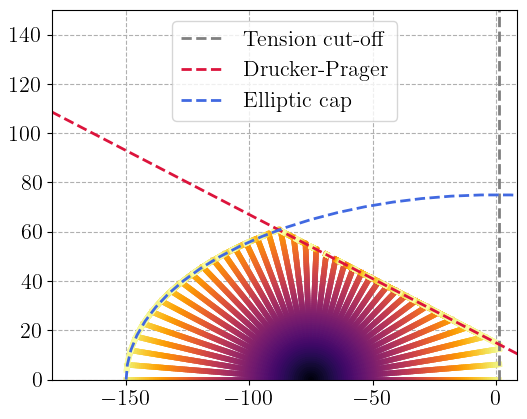

In [ ]:
p_DP = jnp.linspace(-2 * sigc, 2 * sigc, Nincr)
q_DP = jnp.sqrt(3) * (tauc - alpha * 3 * p_DP)
q_cap = M * sigc * jnp.sin(theta)
p_cap = sigc * jnp.cos(theta)
ax.axvline(x=sig0 / 10, linestyle="--", color="grey", label="Tension cut-off")
ax.plot(p_DP, q_DP, linestyle="--", color="crimson", label="Drucker-Prager")
ax.plot(p_cap, q_cap, linestyle="--", color="royalblue", label="Elliptic cap")
ax.legend()
ax.set_aspect("equal")
ax.set_xlim(-1.2 * sigc, tauc)
ax.set_ylim(0, sigc)
plt.show()